In [1]:
import numpy as np
import rescomp

import matplotlib.pyplot as plt

In [26]:
# KS system:

dimensions = 64
system_size = 35
def data_creation_function_KS(time_steps, dt, starting_point=None):
    sim_data = rescomp.simulate_trajectory(
            sys_flag='kuramoto_sivashinsky', dimensions=dimensions, system_size=system_size, dt=dt,
            time_steps=time_steps, starting_point = starting_point)
    return sim_data

# Lorenz system
def data_creation_function_Lorenz(time_steps, dt, starting_point=None):
    return  rescomp.simulate_trajectory(
            sys_flag='lorenz', dt=dt, time_steps=time_steps,
            starting_point=starting_point)

In [13]:
def get_lypunov_exponents_diag(data_creation_function, tau, T, N, dt, eps, m, iteration_process=False):
    tau_timesteps = int(tau/dt)
    T_timesteps = int(T/dt)
    
    initial_condition = data_creation_function(tau_timesteps, dt, starting_point=None)[-1] # discard transient states
    state_dim = initial_condition.size
    if m>state_dim:
        print("ERROR: m > state_dim")
        return
    # choose initial orthogonal directions:
    Q = np.eye(m, state_dim)
    print("Q: ", Q)
    
    # Space to save u_js:
    U = np.zeros((N+1, state_dim))
    U[0, :] = initial_condition
    
    PsiQ = np.zeros(Q.shape)
    
    R_diags = np.zeros((N, m))
    
    for j in range(1, N+1): # for all time intervals
        u_jm1 = U[j-1, :]
        u_j = data_creation_function(T_timesteps, dt, starting_point = u_jm1)[-1]
        U[j, :] = u_j
        for i in range(m): # for all dimensions
            q_i = Q[i, :] # the (j-1)th Q
#             print("qi: ", q_i)
            u_jm1_per = u_jm1 + eps*q_i
            w_i_j = data_creation_function(T_timesteps, dt, starting_point = u_jm1_per)[-1]
            PsiQ[i, :] = (w_i_j - u_j)/eps # approximation of Psi(t_j, t_jm1)q_i(j_m1)
        
        Q, R = np.linalg.qr(PsiQ.T) # the new Q (the jth)
        d = np.diag(np.sign(np.diag(R)))
        Q = Q.dot(d)
        R = d.dot(R)
        Q = Q.T
        #print("R_shape: ", R.shape)
        #print("R: ", R)
        #print("Q: ", Q)
        for i in range(m):
            R_diags[j-1, i] = R[i, i].copy()

    if iteration_process:
        return np.cumsum(np.log(np.abs(R_diags))/(N*T), axis = 0)
    
    lyapunov_exp = np.sum(np.log(np.abs(R_diags))/(N*T), axis = 0)
    return lyapunov_exp

def get_lypunov_exponents_abs(data_creation_function, tau, T, N, dt, eps, m, iteration_process=False):
    tau_timesteps = int(tau/dt)
    T_timesteps = int(T/dt)
    
    initial_condition = data_creation_function(tau_timesteps, dt, starting_point=None)[-1] # discard transient states
    state_dim = initial_condition.size
    if m>state_dim:
        print("ERROR: m > state_dim")
        return
    # choose initial orthogonal directions:
    Q = np.eye(m, state_dim)
    print("Q: ", Q)
    
    # Space to save u_js:
    U = np.zeros((N+1, state_dim))
    U[0, :] = initial_condition
    
    PsiQ = np.zeros(Q.shape)
    
    R_diags = np.zeros((N, m))
    
    for j in range(1, N+1): # for all time intervals
        u_jm1 = U[j-1, :]
        u_j = data_creation_function(T_timesteps, dt, starting_point = u_jm1)[-1]
        U[j, :] = u_j
        for i in range(m): # for all dimensions
            q_i = Q[i, :] # the (j-1)th Q
#             print("qi: ", q_i)
            u_jm1_per = u_jm1 + eps*q_i
            w_i_j = data_creation_function(T_timesteps, dt, starting_point = u_jm1_per)[-1]
            PsiQ[i, :] = (w_i_j - u_j)/eps # approximation of Psi(t_j, t_jm1)q_i(j_m1)
        
        Q, R = np.linalg.qr(PsiQ.T) # the new Q (the jth)
        # d = np.diag(np.sign(np.diag(R)))
        # Q = Q.dot(d)
        #  R = d.dot(R)
        Q = Q.T
        #print("R_shape: ", R.shape)
        #print("R: ", R)
        #print("Q: ", Q)
        for i in range(m):
            # R_diags[j-1, i] = np.abs(R[i, i]).copy()
            R_diags[j-1, i] = R[i, i]

    if iteration_process:
        return np.cumsum(np.log(np.abs(R_diags))/(N*T), axis = 0)
    
    lyapunov_exp = np.sum(np.log(np.abs(R_diags))/(N*T), axis = 0)
    return lyapunov_exp



In [23]:
# best one sofar
def get_lypunov_exponents_minimal(data_creation_function, tau, T, N, dt, eps, m, iteration_process=False):
    
    # setting up
    tau_timesteps = int(tau/dt)
    T_timesteps = int(T/dt)
    initial_condition = data_creation_function(tau_timesteps, dt, starting_point=None)[-1] # discard transient states
    state_dim = initial_condition.size
    if m>state_dim:
        print("ERROR: m > state_dim")
        return
    
    # choose initial orthogonal directions:
    Q = np.eye(state_dim, m)
    
    # Space to save u_js:
    U = np.zeros((state_dim, N+1))
    U[:, 0] = initial_condition
    
    PsiQ = np.zeros(Q.shape)
    
    R_diags = np.zeros((N, m))
    
    for j in range(1, N+1): # for all time intervals
        u_jm1 = U[:, j-1]
        u_j = data_creation_function(T_timesteps, dt, starting_point = u_jm1)[-1]
        U[:, j] = u_j
        for i in range(m): # for all dimensions
            q_i = Q[:, i] # the (j-1)th Q
            u_jm1_per = u_jm1 + eps*q_i
            w_i_j = data_creation_function(T_timesteps, dt, starting_point = u_jm1_per)[-1]
            PsiQ[:, i] = (w_i_j - u_j)/eps # approximation of Psi(t_j, t_jm1)q_i(j_m1)
        
        Q, R = np.linalg.qr(PsiQ) # the new Q (the jth)

        Q = Q

        for i in range(m):
            R_diags[j-1, i] = R[i, i]

    if iteration_process:
        return np.cumsum(np.log(np.abs(R_diags))/(N*T), axis = 0)
    
    lyapunov_exp = np.sum(np.log(np.abs(R_diags))/(N*T), axis = 0)
    return lyapunov_exp

In [ ]:
# Joshkas Function
def equation_based_lyapunov_spectrum_discrete(f, Jacobian, starting_point,
                                              nr_steps=3000, dt=1.,
                                              return_convergence=False):
    """ Calculates the lyapunov spectrum of a discrete dynamical system
    with x_n+1 = f(x_n) using a standard QR-based algorithm.

    Based on equations not data.

    Measure for chaotic behaviour in the system.

    Important characteristic to compare attractors.

    Args:
        f (function): mapping with x_n+1 = f(x_n)
        Jacobian (function): Jacobian of f , takes x as argument
        starting_point (np.ndarray): inintial condition of iteration
        nr_steps (int): number of iteration steps
        dt (float): time scale of a step
        return_convergence (bool): if True returns the development of the
                estimate for the lyapunov spectrum over time in steps of 100
                iterations.

    Returns:
        np.ndarray_or_tuple : lyapunov spectrum if return_convergence is False,
                                tuple of final lyapunov spectrum and development
                                of lyapunov spectrum if return_convergence is
                                True


     """
    x = starting_point

    # jac = Jacobian(x)
    # jac_sparse = scipy.sparse.csr_matrix(Jacobian(x))

    Q, R = np.linalg.qr(Jacobian(x))

    s = []
    lces = []

    for n in range(nr_steps):
        x = f(x)
        Q, R = np.linalg.qr(np.matmul(Jacobian(x), Q))

        s.append(np.array([R[i, i] for i in range(len(R))]))

        # if n % 100 == 0 and return_convergence:
        #     lya = np.sum(np.log(np.abs(s)), axis=0) / (n * dt)
        #     lces.append(lya)

        if return_convergence:
            lya = np.sum(np.log(np.abs(s)), axis=0) / ((n + 1) * dt)
            lces.append(lya)

    lya = np.sum(np.log(np.abs(s)), axis=0) / (nr_steps * dt)

    if return_convergence:
        return lya, np.array(lces)
    else:
        return lya

# Lorenz:

# KS:

[ 0.06827366  0.0379146   0.01533185  0.00112806 -0.00095665 -0.02340826
 -0.05514473 -0.1043062  -0.18144116 -0.26818694]


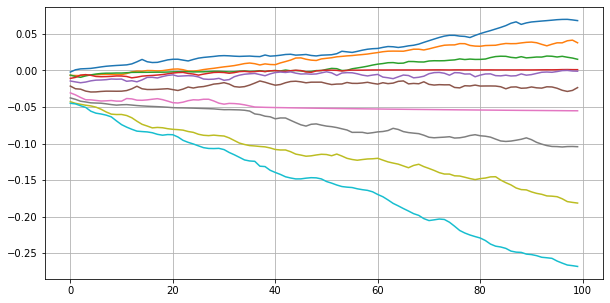

In [30]:
# diag function

data_creation_function = data_creation_function_KS
get_lypunov_exponents = get_lypunov_exponents_minimal

iterations = get_lypunov_exponents(data_creation_function, tau=2000, T=2, N=100, dt=0.1, 
                                   eps=1e-6, m=10, iteration_process=True)


plt.figure(figsize=(10,5))
plt.plot(iterations)
plt.grid()
print(iterations[-1])

[0.05087214 0.03425996]


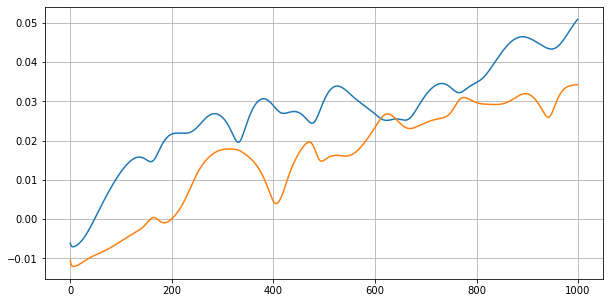

In [27]:
# abs function

data_creation_function = data_creation_function_KS
get_lypunov_exponents = get_lypunov_exponents_minimal

iterations = get_lypunov_exponents(data_creation_function, tau=5, T=0.1, N=1000, dt=0.01, 
                                   eps=1e-6, m=2, iteration_process=True)
plt.figure(figsize=(10,5))
plt.plot(iterations)
plt.grid()
print(iterations[-1])

In [20]:
# Matrix tests to understand the axis conventions in numpy:
# >>> first index is the row second index is the column
# >>> first index moves in most nested list 

A = np.zeros((2,2))
B = np.array([[4,2], [1,3]])

A[0,0] = 1
A[0,1] = 2
A[1,0] = 3
A[1,1] = 4
print(A)
print(B)

[[1. 2.]
 [3. 4.]]
[[4 2]
 [1 3]]


In [21]:
A[0]

array([1., 2.])

In [22]:
A.dot(B)

array([[ 6.,  8.],
       [16., 18.]])